In [482]:
import re
from konlpy.tag import Kkma, Hannanum, Twitter
import string
kkma = Kkma()
hannanum = Hannanum()
twitter = Twitter()
remove_punct_map = dict.fromkeys(map(ord, string.punctuation))
remove_quotes_map = dict([(ord(x), " ") for x in ".․,‘’´“”·‧<>「」–-()~"]) 

def clean_title(title):
    # Remove punctuation
    title = title.replace("…", " ")
    title = title.translate(remove_punct_map)
    title = title.translate(remove_quotes_map)
    title = re.sub('\s+', ' ', title)
    return title

def filter_words(nouns):
    # Remove words with digits
    nouns = filter(lambda word: not any(char.isdigit() for char in word), nouns)
    # Remove blacklisted words
    badwords = ["수", "년", "등", "및", "몇", '네이버', '뉴스']
    badwords += ["공급", "설치", "조성", "운영", "설립", "확대", "건설", "제공"]
    nouns = filter(lambda word: word not in badwords, nouns)
    return list(nouns)

def title2nouns(title):
    return filter_words(hannanum.nouns(clean_title(title)))
    
def title2list(title):
    """Gather important nouns from a Korean text"""
    title = clean_title(title)
    titlewords = title.strip().split()

    nouns = []
    
    # Add special words
    if any(word != "대로" and word.endswith("대로") for word in titlewords):
        nouns.append("대로")
    if any(word != "도로" and word.endswith("도로") for word in titlewords):
        nouns.append("도로")

    # Gather relevant nouns from twitter and hannanum corpus
    for aword in titlewords:
        tlist = twitter.nouns(aword)
        hlist = hannanum.nouns(aword)
        htlist = list(set(hlist) - set(tlist))  # only in Hannanum
        thlist = list(set(tlist) - set(hlist))  # only in Twitter
        ilist = list(set(hlist) & set(tlist))   # in both
        
        # Add nouns that occur in both corpus
        nouns = nouns + ilist

        # Add all nouns from Twitter corpus that are long enough
        nouns = nouns + list(filter(lambda word: len(word) > 1, thlist))

        # Add nouns from Hannanum corpus that are non divisible (root noun)
        for htword in htlist:
            if len(htword) > 2:
                newlist = twitter.nouns(htword)
                if len(newlist) < 2:
                    nouns.append(htword)

    nouns = filter_words(nouns)
    return list(set(list(nouns)))

In [483]:
title = '신혼부부‧학생‧일인가구 등 수요대응형 주택공급 및 임대주택 지속 공급'
title = ' 임대주택 등록하면 세금·건보료 감면…2020년 등록 의무화 검토'
#title2list(title)
a = hannanum.nouns(clean_title(title))
print(a)
b = twitter.nouns(clean_title(title))
print(b)
c = title2list(title)
print(c)  # Note that title2list changes the order which is not good for doc2vec
d = title2nouns(title)
print(d)

['임대주택', '등록', '세금', '건보료', '감면', '2020년', '등록', '의무화', '검토']
['임대주택', '세금', '건', '보료', '년', '등록', '의무', '검토']
['의무', '세금', '검토', '보료', '등록', '임대주택', '의무화']
['임대주택', '등록', '세금', '건보료', '감면', '등록', '의무화', '검토']


In [484]:
%%time
import json

all_promises = []

with open('jisa_tagged.json') as data_file:    
    data = json.load(data_file)
    i = 0
    for voting_district in data:
        promises = voting_district['promises']
        for p in promises:
            title_clean = title2nouns(p['title'])
            all_promises.append((p['title'], title_clean, [i], ))
            i += 1

CPU times: user 5.77 s, sys: 74.6 ms, total: 5.85 s
Wall time: 4.12 s


In [485]:
from gensim.models.doc2vec import TaggedDocument
import gensim

In [486]:
class DocIterator(object):
    def __init__(self, data):
        self.data = data

    def __iter__(self):
        for idx, doc in enumerate(self.data):
            tokens = self.data[idx][1]
            labels = self.data[idx][2]
            yield TaggedDocument(words=tokens, tags=labels)

documents = DocIterator(all_promises)

In [487]:
model = gensim.models.Doc2Vec(size=150, window=10, min_count=1, workers=4, alpha=0.1, min_alpha=0.01, iter=50) # use fixed learning rate
model.build_vocab(documents)

In [488]:
%%time
model.train(documents, total_examples=model.corpus_count, epochs=model.iter)

CPU times: user 4.89 s, sys: 1.53 s, total: 6.42 s
Wall time: 5.2 s


431171

In [90]:
import requests
article_url = "http://news.naver.com/main/hotissue/read.nhn?mid=hot&sid1=101&cid=957181&iid=2702402&oid=001&aid=0009747960&ptype=052"
api_url = 'https://api.budgetwiser.org/api/news/get_by_url/'
article_parsed = requests.get(api_url, {'url': article_url}).json()

In [509]:
#search = article_parsed['title_keywords'] # text, title, title_keywords
search = title2nouns(article_parsed['title'])
docvec = model.infer_vector(search)
similar = model.docvecs.most_similar([docvec], topn=5)

In [510]:
print("Most similar to article %s (%s)" % (article_parsed['title'][:50], ' '.join(search)))
for key, score in similar:
    print('%4d %.4f %s (%s)' %(key, score, all_promises[key][0], ' '.join(all_promises[key][1])))

Most similar to article 임대주택 등록하면 세금·건보료 감면…2020년 등록 의무화 검토 : 네이버 뉴스 (임대주택 등록 세금 건보료 감면 등록 의무화 검토)
1048 0.8372 소정면 임대주택 건설 (소정면 임대주택)
1155 0.8260 장기공공 임대주택 공급 (장기공공 임대주택)
1742 0.8101 빈집활용 반값 임대주택 제공 (빈집활용 반값 임대주택)
 616 0.7965 기존사업 원점 재검토(재정여건 감안 우선순위 검토) (기존사업 원점 재검토재정여건 감안 우선순위 검토)
1598 0.7540 신혼부부‧학생‧일인가구 등 수요대응형 주택공급 및 임대주택 지속 공급 (신혼부부 학생 일인가구 수요대응형 주택공급 임대주택 지속)


In [145]:
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.manifold import TSNE

In [442]:
X = model.docvecs
X = np.reshape(X, (len(model.docvecs), len(model.docvecs[0])))

In [443]:
%%time
tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
result = tsne.fit_transform(X) 


CPU times: user 20.6 s, sys: 2.78 s, total: 23.4 s
Wall time: 24.7 s


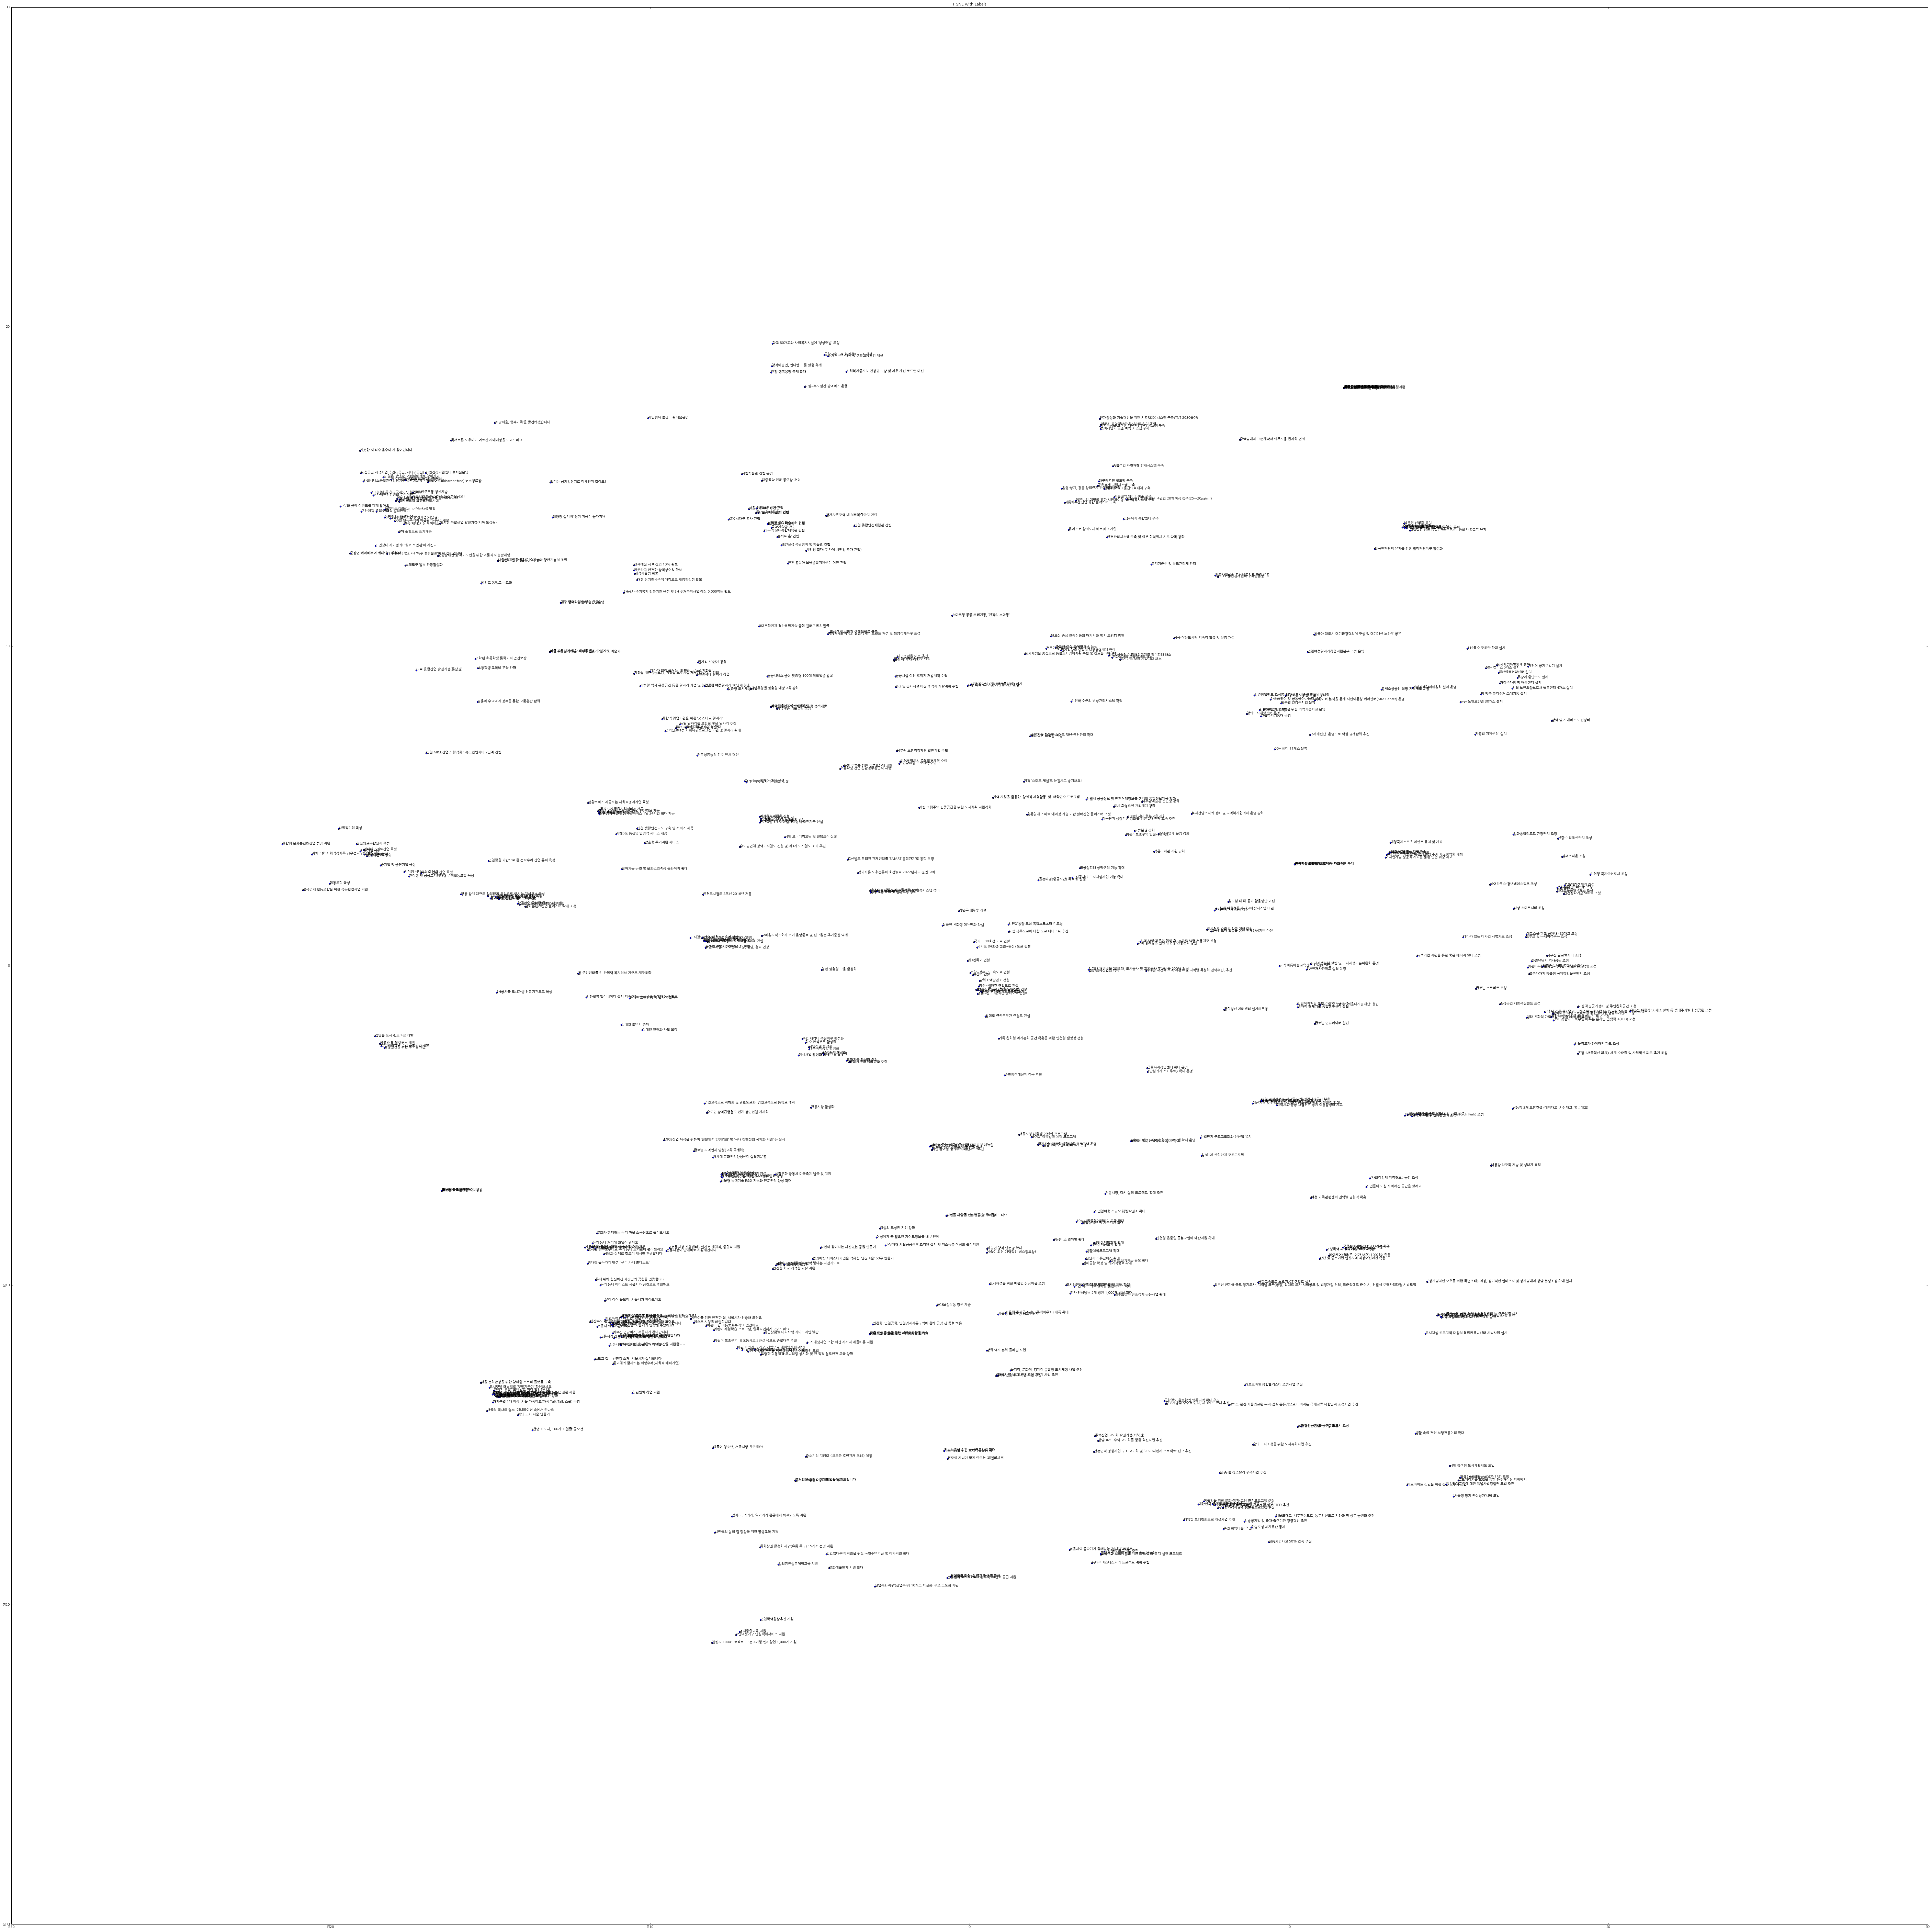

In [444]:
import matplotlib
matplotlib.rc('font', family='NanumGothic')

labels = [doc[0] for doc in all_promises]

#labeled plotting
z=result[:600, 0]
y=result[:600, 1]

fig, ax = plt.subplots(figsize=(100, 100))
ax.scatter(z, y)


for i, txt in enumerate(labels[:600]):
    ax.annotate(txt, (z[i], y[i]))

plt.title("T-SNE with Labels")
plt.show()

In [149]:
len(labels)

2086